# Assignment - Recommender System

You are the sales manager for "BeerMart", an online beer store in the United States. You want to build a recommendation system (collaborative) for your store, where customers will be recommended the beer that they are most likely to buy. You collect data about the ratings that the customers have given in the past. <br>
Description: Each record includes a beer's name and the user's name, along with the ratings he/she has given to the beer. All ratings are on a scale from 1 to 5, with 5 being the best rating.<br><br>
As you solve the case study, you need to complete the following tasks:<br>

Data preparation:
- Choose only those beers that have at least N number of reviews.
    Figure out an appropriate value of N using EDA; this may not have one correct answer, but you should not choose beers that have an extremely low number of ratings.


Data exploration
- What are the unique values of ratings?
- Visualise the rating values and notice:
- The average beer ratings
- The average user ratings
- The average number of ratings given to the beers
- The average number of ratings given by the users


Recommendation Models
- Divide your data into training and testing dataset.
- Build user-based and item-based models.
- Determine how similar the first 10 users are to each other and visualise it.
- Compute and visualise the similarity between the first 10 beers.
- Compare the performance of the two models using test data and suggest the one that should be deployed.
- Give the names of the top 5 beers that you would recommend to the users 'cokes', 'genog' and 'giblet' using both the models.

In [1]:
# import libraties
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Reading ratings file
beer = pd.read_csv('beer_data.csv')

In [2]:
beer.shape

(475984, 3)

In [3]:
beer.head()

,beer_beerid,review_profilename,review_overall
0,48215,stcules,3.0
1,52159,oline73,3.0
2,52159,alpinebryant,3.0
3,52159,rawthar,4.0
4,52159,RangerClegg,3.5


### Data Preparation

Checking for Null Values in the dataset

In [4]:
# Let's check for any null values in the dataset
beer.isnull().sum()

beer_beerid             0
review_profilename    100
review_overall          0
dtype: int64

In [5]:
# We can see that there are a few null values in the review_profilename column of the dataset

In [6]:
# let's have a look at those columns with the null values
beer.loc[beer.isnull()['review_profilename'],:].head()

,beer_beerid,review_profilename,review_overall
2700,29687,NaN,4.0
9545,5441,NaN,4.0
12252,1504,NaN,4.5
25270,1904,NaN,4.5
33728,2130,NaN,2.5


In [7]:
# Let's go ahead and drop these rows with null values
beer_refined = beer.loc[~beer.isnull()['review_profilename'],:]

In [8]:
# Checking presence of null values in the cleaned dataset
beer_refined.isnull().sum()

beer_beerid           0
review_profilename    0
review_overall        0
dtype: int64

Let's also ensure that we don't have any duplicate values in our dataset. In case there does exist such values, let's drop them

In [9]:
print('original dataset shape:', beer_refined.shape)
print('dataset shape after checking and dropping duplicate values', beer_refined.drop_duplicates().shape)

original dataset shape: (475884, 3)
dataset shape after checking and dropping duplicate values (475304, 3)


In [10]:
# We see that there indeed are duplicate values, let's go ahead and drop them
beer_refined = beer_refined.drop_duplicates()

Next, we've been asked to **choose only those beers that have at least N number of reviews**. This can be figured out post performing EDA to find out the beers that have very low number of ratings and exclude them

In [11]:
beer_refined['beer_beerid'].nunique()

40304

In [12]:
# Let's identify the distribution of the number of reviews for different beers
beer_freq = pd.DataFrame(beer_refined.groupby('beer_beerid')['beer_beerid'].count())
beer_freq.columns = ['freq']

In [13]:
beer_freq = beer_freq.reset_index()

{'whiskers': [<matplotlib.lines.Line2D at 0x299c9ef9908>,
 'caps': [<matplotlib.lines.Line2D at 0x299c9ef9f98>,
 'boxes': [<matplotlib.lines.Line2D at 0x299c9ef9518>],
 'medians': [<matplotlib.lines.Line2D at 0x299c9f11668>],
 'fliers': [<matplotlib.lines.Line2D at 0x299c9f119b0>],
 'means': []}

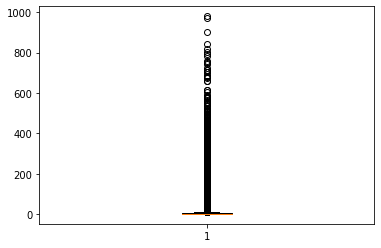

In [14]:
# Plotting the above distribution as a boxplot
plt.boxplot(beer_freq.loc[:, 'freq'])

In [15]:
# Let's identify the distribution of the number of reviews for different beers
freq_dist = pd.DataFrame(beer_freq.groupby('freq')['freq'].count())
freq_dist.columns = ['count']
freq_dist = freq_dist.reset_index()

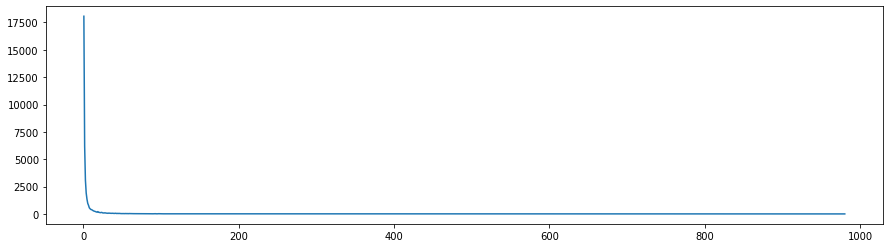

In [16]:
# Plotting the distribution of frequency against count of values for the above data in a line chart
fig = plt.figure(figsize=(15,4))
# plt.plot(freq_dist.loc[freq_dist['freq']<100, 'freq'], freq_dist.loc[freq_dist['freq']<100, 'count'])
plt.plot(freq_dist['freq'], freq_dist['count'])

In [17]:
# Identifying the share of beers that have only 1 review
print('Share of beers with only 1 review' , 100 * freq_dist.loc[freq_dist['freq']==1, 'count'].sum()/freq_dist['count'].sum())

# Identifying the share of beers that have only <= 2 review
print('Share of beers with at most 2 reviews' , 100 * freq_dist.loc[freq_dist['freq']<=2, 'count'].sum()/freq_dist['count'].sum())

# Identifying the share of beers that have only <= 3 review
print('Share of beers with at most 3 reviews' , 100 * freq_dist.loc[freq_dist['freq']<=3, 'count'].sum()/freq_dist['count'].sum())

# Identifying the share of beers that have only <= 4 review
print('Share of beers with at most 4 reviews' , 100 * freq_dist.loc[freq_dist['freq']<=4, 'count'].sum()/freq_dist['count'].sum())


Share of beers with only 1 review 44.8243350535927
Share of beers with at most 2 reviews 60.177649861055976
Share of beers with at most 3 reviews 67.79972211194918
Share of beers with at most 4 reviews 72.52878126240572


In [18]:
# We observe that ~70% of beers have at most 4 reviews. Let's go ahead and work with beers that have atleast 5 reviews or more.
# Therefore, we'll use N = 5 (where N = minimum number of reviews for any beer to be considered for our system)
# The value N=5 seems to be appropriate since it would be a good number of reviews to deem whether users liked the beer or not

In [19]:
# Filtering our data so that it only has data for beers with atleast N=5 number of reviews

# First, let's identify all the beer id's that have at least 3 or more reviews
filtered_beerids = beer_freq.loc[beer_freq['freq']>=5, 'beer_beerid'].unique()

# Next, let's create a subset of our original dataset so that it only has data corresponding to the above identified beer id's
beer_refined = beer_refined.loc[beer_refined['beer_beerid'].isin(filtered_beerids), :]

In [20]:
# Let's check whether we now have data for beers with min number of reviews equal to 5
beer_freq2 = pd.DataFrame(beer_refined.groupby('beer_beerid')['beer_beerid'].count())
beer_freq2.columns = ['freq']
beer_freq2 = beer_freq2.reset_index()
beer_freq2.sort_values(by='freq', ascending = True).head()

,beer_beerid,freq
9266,54568,5
8817,50882,5
8818,50885,5
1085,1858,5
2323,5155,5


In [21]:
beer_refined.shape

(428022, 3)

In [22]:
beer_refined.head()

,beer_beerid,review_profilename,review_overall
5,58046,mikedrinksbeer2,4.5
6,58046,dbmernin83,4.0
7,58046,Blakaeris,4.5
8,58046,bashiba,4.5
9,58046,oberon,4.0


### Data Exploration

What are the unique values of ratings?

In [23]:
beer_refined['review_overall'].value_counts()

4.0    158332
4.5     89620
3.5     80477
3.0     43213
5.0     25464
2.5     15032
2.0      9905
1.5      3193
1.0      2786
Name: review_overall, dtype: int64

Visualise the rating values and notice:
- The average beer ratings
- The average user ratings
- The average number of ratings given to the beers
- The average number of ratings given by the users

In [24]:
# In order to find the average beer ratings, let's aggregate the ratings by beers and find the corresponding average
beer_rating = beer_refined.groupby('beer_beerid')['review_overall'].mean()
beer_rating.columns = ['average_rating']
beer_rating = beer_rating.reset_index()
beer_rating.head()

,beer_beerid,review_overall
0,4,3.666667
1,5,3.553097
2,6,3.711462
3,7,3.317961
4,8,3.543478


{'whiskers': [<matplotlib.lines.Line2D at 0x299ca01db00>,
 'caps': [<matplotlib.lines.Line2D at 0x299ca02c240>,
 'boxes': [<matplotlib.lines.Line2D at 0x299ca01d9b0>],
 'medians': [<matplotlib.lines.Line2D at 0x299ca02c8d0>],
 'fliers': [<matplotlib.lines.Line2D at 0x299ca02cf28>],
 'means': [<matplotlib.lines.Line2D at 0x299ca02cc18>]}

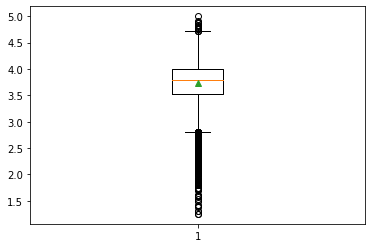

In [25]:
# Let's use a boxplot to visualize the beer ratings column
plt.boxplot(beer_rating['review_overall'], showmeans=True)

In [26]:
# We observe that there are a few rating below ~2.75 and ratings above ~4.75 of the spectrum that act as outliers
# From the distribution, we observe that the 50th percetile of lies close to 3.7
# Let's confirm the average value of beer rating from our distribution
print('The average beer rating is', round(beer_rating['review_overall'].mean(),2))

The average beer rating is 3.72


In [27]:
# In order to find the average user ratings, let's aggregate the ratings by users and find the corresponding average
user_rating = beer_refined.groupby('review_profilename')['review_overall'].mean()
user_rating.columns = ['average_rating']
user_rating = user_rating.reset_index()
user_rating.head()

,review_profilename,review_overall
0,0110x011,4.303030
1,01Ryan10,5.000000
2,03SVTCobra,1.000000
3,04101Brewer,4.000000
4,05Harley,4.175676


{'whiskers': [<matplotlib.lines.Line2D at 0x299ca2629e8>,
 'caps': [<matplotlib.lines.Line2D at 0x299ca26f128>,
 'boxes': [<matplotlib.lines.Line2D at 0x299ca262898>],
 'medians': [<matplotlib.lines.Line2D at 0x299ca26f7b8>],
 'fliers': [<matplotlib.lines.Line2D at 0x299ca26fe10>],
 'means': [<matplotlib.lines.Line2D at 0x299ca26fb00>]}

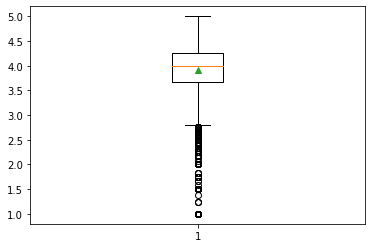

In [28]:
# Let's use a boxplot to visualize the user ratings column
plt.boxplot(user_rating['review_overall'], showmeans=True)

In [29]:
# We observe that there are a few rating below ~2.75 that act as outliers.
# From the distribution, we observe that the 50th percetile of lies close to 4
# Let's confirm the average value of beer rating from our distribution
print('The average user rating is', round(user_rating['review_overall'].mean(),2))

The average user rating is 3.92


In [30]:
# In order to find the average number of ratings given to the beers, let's aggregate the ratings by beers and find the corresponding count
beer_rating_cnt = pd.DataFrame(beer_refined.groupby('beer_beerid')['beer_beerid'].count())
beer_rating_cnt.columns = ['rating_count']
beer_rating_cnt = beer_rating_cnt.reset_index()
beer_rating_cnt.head()

,beer_beerid,rating_count
0,4,6
1,5,113
2,6,253
3,7,206
4,8,23


{'whiskers': [<matplotlib.lines.Line2D at 0x299ca2cfcf8>,
 'caps': [<matplotlib.lines.Line2D at 0x299ca2dc438>,
 'boxes': [<matplotlib.lines.Line2D at 0x299ca2cfba8>],
 'medians': [<matplotlib.lines.Line2D at 0x299ca2dcac8>],
 'fliers': [<matplotlib.lines.Line2D at 0x299ca2e8160>],
 'means': [<matplotlib.lines.Line2D at 0x299ca2dce10>]}

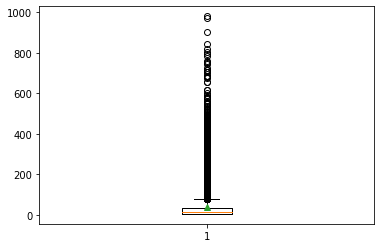

In [31]:
# Let's use a boxplot to visualize the beer rating count column
plt.boxplot(beer_rating_cnt['rating_count'], showmeans=True)

In [32]:
# It's hard to tell from the distribution what the mean is due to the presence of many outliers
# Let's confirm the mean value of rating count for beers
print('The average number of ratings given to the beers is', round(beer_rating_cnt['rating_count'].mean()))

The average number of ratings given to the beers is 39


In [33]:
# The above value is highly skewed due to the presence of outliers in the dataset
# A better estimate of the central tendency in this case would be the median
print('The median number of ratings given to the beers is', round(beer_rating_cnt['rating_count'].median()))

The median number of ratings given to the beers is 13


In [34]:
# In order to find the average number of ratings given by the users, let's aggregate the ratings by users and find the corresponding count
user_rating_cnt = pd.DataFrame(beer_refined.groupby('review_profilename')['beer_beerid'].count())
user_rating_cnt.columns = ['rating_count']
user_rating_cnt = user_rating_cnt.reset_index()
user_rating_cnt.head()

,review_profilename,rating_count
0,0110x011,33
1,01Ryan10,1
2,03SVTCobra,1
3,04101Brewer,1
4,05Harley,37


{'whiskers': [<matplotlib.lines.Line2D at 0x299ca330f60>,
 'caps': [<matplotlib.lines.Line2D at 0x299ca33f6a0>,
 'boxes': [<matplotlib.lines.Line2D at 0x299ca330e10>],
 'medians': [<matplotlib.lines.Line2D at 0x299ca33fd30>],
 'fliers': [<matplotlib.lines.Line2D at 0x299ca34b3c8>],
 'means': [<matplotlib.lines.Line2D at 0x299ca34b0b8>]}

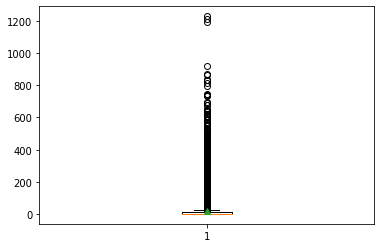

In [35]:
# Let's use a boxplot to visualize the user rating count column
plt.boxplot(user_rating_cnt['rating_count'], showmeans=True)

In [36]:
# It's hard to tell from the distribution what the mean is due to the presence of many outliers
# Let's confirm the mean value of rating count for beers
print('The average number of ratings given by the users is', round(user_rating_cnt['rating_count'].mean()))

The average number of ratings given by the users is 20


In [37]:
# The above value is highly skewed due to the presence of outliers in the dataset
# A better estimate of the central tendency in this case would be the median
print('The median number of ratings given by the users is', round(user_rating_cnt['rating_count'].median()))

The median number of ratings given by the users is 3


PS. The above analysis and solutions provided for the questions asked are performed on the dataset where the filter for minimum number of reviews N (=5 in our case) was applied

Now that we've performed the required data preparation and exploration steps, let's go ahead and create our recommender system

### Recommendation Models

In [38]:
# Looking at the dataset, it appears that there are cases where 1 user has rated a beer more than once
# In order to feed this data to our recommender system, let's take the average rating given by any user to any beer
beer_refined2 = pd.DataFrame(beer_refined.groupby(['beer_beerid','review_profilename'])['review_overall'].mean())
beer_refined2 = beer_refined2.reset_index()

Divide the data into training and testing dataset.

In [39]:
# Splitting the data into test (30%) - train (70%)
from sklearn.model_selection import train_test_split
train, test = train_test_split(beer_refined2, test_size=0.30, random_state=31)

In [40]:
print(train.shape)
print(test.shape)

(299052, 3)
(128166, 3)


**Builiding User-Based Recommendation Model** 

In [41]:
# pivot ratings into movie features
df_user_based = train.pivot(index='review_profilename', columns='beer_beerid', values='review_overall').fillna(0)

In [42]:
df_user_based.head()

beer_beerid,4,5,6,7,8,9,10,11,12,13,...,75978,76144,76170,76192,76323,76375,76440,76521,76525,76816
review_profilename,,,,,,,,,,,,,,,,,,,,,
0110x011,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
03SVTCobra,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
04101Brewer,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
05Harley,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0beerguy0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [43]:
# Copy train and test dataset as these datasets will be used for prediction and evaluation
dummy_train = train.copy()
dummy_test = test.copy()

In [44]:
dummy_train.head()

,beer_beerid,review_profilename,review_overall
367775,47678,tigg924,4.0
257602,20954,Alkey,4.5
288986,29211,sulldaddy,4.0
236038,16074,Jeebs,4.5
317032,36028,HUXC,4.0


In [45]:
# Dummy train will be used for prediction of the beers which has not been rated by the user. 
# To ignore the beers already rated by the user, we will mark it as 0 during prediction. 
# The beers not rated by user is marked as 1 for prediction. 
dummy_train['review_overall'] = dummy_train['review_overall'].apply(lambda x: 0 if x>=1 else 1)

# Dummy test will be used for evaluation. 
# To evaluate, we will only make prediction on the beers rated by the user. So, this is marked as 1
dummy_test['review_overall'] = dummy_test['review_overall'].apply(lambda x: 1 if x>=1 else 0)

In [46]:
# The beers not rated by user is marked as 1 for prediction. 
dummy_train = dummy_train.pivot(
    index='review_profilename',
    columns='beer_beerid',
    values='review_overall'
).fillna(1)

# The beers not rated by user is marked as 0 for evaluation. 
dummy_test = dummy_test.pivot(
    index='review_profilename',
    columns='beer_beerid',
    values='review_overall'
).fillna(0)

In [47]:
dummy_train.head()

beer_beerid,4,5,6,7,8,9,10,11,12,13,...,75978,76144,76170,76192,76323,76375,76440,76521,76525,76816
review_profilename,,,,,,,,,,,,,,,,,,,,,
0110x011,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
03SVTCobra,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
04101Brewer,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
05Harley,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
0beerguy0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [48]:
dummy_test.head()

beer_beerid,4,5,6,7,8,9,10,11,12,13,...,75978,76144,76170,76192,76323,76375,76440,76521,76525,76816
review_profilename,,,,,,,,,,,,,,,,,,,,,
0110x011,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
01Ryan10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
05Harley,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0tt0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1001111,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**User Similarity Matrix - Using the Adjusted Cosine Similarity metric**

In [49]:
# Since we'll be using the adjusted cosine similarity between users, we won't be filling up the NaN values with 0's
# Hence, we'll only be calculating calculating the mean for the beers rated by the user
df_user_based2 = train.pivot(index='review_profilename', columns='beer_beerid', values='review_overall')

In [50]:
df_user_based2.head()

beer_beerid,4,5,6,7,8,9,10,11,12,13,...,75978,76144,76170,76192,76323,76375,76440,76521,76525,76816
review_profilename,,,,,,,,,,,,,,,,,,,,,
0110x011,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
03SVTCobra,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
04101Brewer,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
05Harley,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0beerguy0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [51]:
# Normalising the rating of the beers by each user such that the mean is at 0
mean = np.nanmean(df_user_based2, axis=1)
df_subtracted = (df_user_based2.T-mean).T

In [52]:
# Finding the Cosine Similarity
from sklearn.metrics.pairwise import pairwise_distances

# User Similarity Matrix
user_correlation = 1 - pairwise_distances(df_subtracted.fillna(0), metric='cosine')
user_correlation[np.isnan(user_correlation)] = 0
print(user_correlation)

[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


Predictions

In [53]:
# We'll only be considering those users that have a positive correlation with a particular user for the predictions
# Because, these are the ones that show some level of similarity (as opposed to the negatively correlated ones)

# Therefore, setting all the negatively correlated values to 0
user_correlation2 = user_correlation.copy()
user_correlation2[user_correlation2<0]=0
user_correlation2

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [54]:
# Rating predicted by the user (for beers rated as well as not rated) is the weighted sum of correlation with the beer rating
user_predicted_ratings = np.dot(user_correlation2, df_user_based2.fillna(0))
user_predicted_ratings

array([[0.        , 0.90602718, 2.51216324, ..., 0.        , 0.1289217 ,
        0.02815832],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.31731927, 0.24009802, ..., 0.        , 0.0593847 ,
        0.18606321],
       [0.        , 1.09276632, 5.74336301, ..., 0.        , 0.16952205,
        0.37766878],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [55]:
user_predicted_ratings.shape

(19263, 11071)

In [56]:
# Since we are interested only in beers not rated by the user, we will ignore the beers rated by the user by making it zero
user_final_rating = np.multiply(user_predicted_ratings,dummy_train)
user_final_rating.head()

beer_beerid,4,5,6,7,8,9,10,11,12,13,...,75978,76144,76170,76192,76323,76375,76440,76521,76525,76816
review_profilename,,,,,,,,,,,,,,,,,,,,,
0110x011,0.000000,0.906027,2.512163,1.413171,0.493424,0.367708,2.473340,0.090509,0.262155,0.155318,...,0.045516,0.357737,0.000000,0.011604,0.052667,0.000000,0.0,0.0,0.128922,0.028158
03SVTCobra,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000
04101Brewer,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000
05Harley,0.394173,2.220338,4.058734,3.669065,0.114971,0.662232,5.763295,0.310490,0.118914,0.428379,...,0.092745,1.579247,0.245678,0.000000,0.000000,0.116143,0.0,0.0,1.290903,0.910409
0beerguy0,0.000000,0.764824,1.680169,0.866190,0.541653,0.037214,1.612565,0.178263,0.149116,0.119740,...,0.149494,0.382934,0.166812,0.000000,0.000000,0.000000,0.0,0.0,0.048930,0.119744


**Determine how similar the first 10 users are to each other and visualise it.**

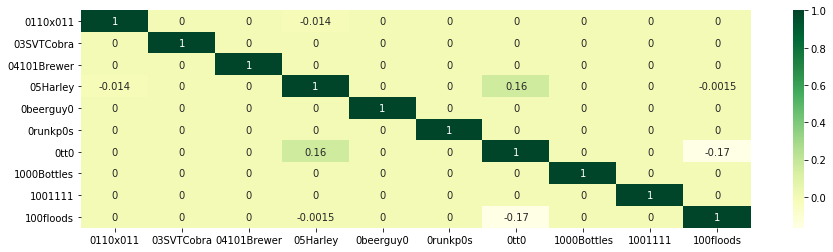

In [57]:
# To answer the above question, let's use a heat map on the similarity matrix created using the adjust consine similarity metric
z_min, z_max = user_correlation[:10, :10].min(), user_correlation[:10, :10].max()

import seaborn as sns
fig = plt.figure(figsize=(15,4))
ax = sns.heatmap(user_correlation[:10, :10], annot=True, cmap='YlGn', vmin=z_min, vmax=z_max)
ax.set_xticklabels(dummy_train.index[:10])
ax.set_yticklabels(dummy_train.index[:10])
plt.yticks(rotation=0) 

plt.show()

**Builiding Item-Based Recommendation Model** 

In [58]:
train.head()

,beer_beerid,review_profilename,review_overall
367775,47678,tigg924,4.0
257602,20954,Alkey,4.5
288986,29211,sulldaddy,4.0
236038,16074,Jeebs,4.5
317032,36028,HUXC,4.0


In [59]:
# Here, we're essentially taking the transform of the user-based matrix, so that we're aggregating the data with beers as index
# Also, since we're using the adjusted cosine similarity, we'll not be replacing NaN values in the data with 0
df_item_based = train.pivot(index='review_profilename', columns='beer_beerid', values='review_overall').T

df_item_based.head()

review_profilename,0110x011,03SVTCobra,04101Brewer,05Harley,0beerguy0,0runkp0s,0tt0,1000Bottles,1001111,100floods,...,zuffenhausen,zuggy9,zulufactor,zwalk8,zwan,zymurgy4all,zymurgywhiz,zythus,zyzygy,zzajjber
beer_beerid,,,,,,,,,,,,,,,,,,,,,
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [60]:
# Normalizing the beer rating to have mean at 0
mean = np.nanmean(df_item_based, axis=1)
df_subtracted = (df_item_based.T-mean).T

In [61]:
df_subtracted.head()

review_profilename,0110x011,03SVTCobra,04101Brewer,05Harley,0beerguy0,0runkp0s,0tt0,1000Bottles,1001111,100floods,...,zuffenhausen,zuggy9,zulufactor,zwalk8,zwan,zymurgy4all,zymurgywhiz,zythus,zyzygy,zzajjber
beer_beerid,,,,,,,,,,,,,,,,,,,,,
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [62]:
# Finding the Cosine Similarity
from sklearn.metrics.pairwise import pairwise_distances

# Item Similarity Matrix
item_correlation = 1 - pairwise_distances(df_subtracted.fillna(0), metric='cosine')
item_correlation[np.isnan(item_correlation)] = 0
print(item_correlation)

[[1.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.00000000e+00 1.85190394e-02 ... 0.00000000e+00
  0.00000000e+00 2.43997894e-04]
 [0.00000000e+00 1.85190394e-02 1.00000000e+00 ... 0.00000000e+00
  1.22271299e-02 0.00000000e+00]
 ...
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.22271299e-02 ... 0.00000000e+00
  1.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.43997894e-04 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 1.00000000e+00]]


Preditions

In [63]:
# We'll only be considering those items that have a positive correlation with a particular item for the predictions
# Because, these are the ones that show some level of similarity (as opposed to the negatively correlated ones)

# Therefore, setting all the negatively correlated values to 0
item_correlation2 = item_correlation.copy()
item_correlation2[item_correlation2<0]=0
item_correlation2

array([[1.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 1.00000000e+00, 1.85190394e-02, ...,
        0.00000000e+00, 0.00000000e+00, 2.43997894e-04],
       [0.00000000e+00, 1.85190394e-02, 1.00000000e+00, ...,
        0.00000000e+00, 1.22271299e-02, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 1.22271299e-02, ...,
        0.00000000e+00, 1.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 2.43997894e-04, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

In [64]:
item_predicted_ratings = np.dot((df_item_based.fillna(0).T),item_correlation2)
item_predicted_ratings

array([[0.        , 0.28688919, 1.50060047, ..., 0.03111519, 0.4490871 ,
        0.12786867],
       [0.        , 0.        , 0.00546814, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.10758335, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.0490412 , 0.01521743, ..., 0.        , 0.        ,
        0.05255958],
       [0.34611672, 0.05378556, 0.18785458, ..., 0.11020483, 0.04075263,
        0.02861459],
       [0.        , 0.03224415, 0.        , ..., 0.        , 0.        ,
        0.03622116]])

In [65]:
print(item_predicted_ratings.shape)
print(dummy_train.shape)

(19263, 11071)
(19263, 11071)


In [66]:
# Since we're interested only in users who haven't rated a beer, we'll ignore users who have rated the beer by making it zero
item_final_rating = np.multiply(item_predicted_ratings,dummy_train)
item_final_rating.head()

beer_beerid,4,5,6,7,8,9,10,11,12,13,...,75978,76144,76170,76192,76323,76375,76440,76521,76525,76816
review_profilename,,,,,,,,,,,,,,,,,,,,,
0110x011,0.000000,0.286889,1.500600,1.385790,0.569030,0.265154,0.711439,0.202338,0.726445,0.000000,...,0.0,0.741747,0.000000,1.328527,0.000000,0.000000,0.119377,0.031115,0.449087,0.127869
03SVTCobra,0.000000,0.000000,0.005468,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
04101Brewer,0.000000,0.000000,0.107583,0.102808,0.140979,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.879519,0.000000,0.000000,0.000000
05Harley,0.165062,0.546635,1.035755,0.852032,0.896901,0.497129,0.735920,0.505735,0.097681,0.292557,...,0.0,0.870439,0.224297,0.000000,0.527025,0.123420,0.816166,0.105159,0.480958,0.111398
0beerguy0,0.000000,0.000000,0.278235,0.124724,0.416214,0.016296,0.017037,0.145330,0.108721,0.042709,...,0.0,0.234367,0.049512,0.000000,0.000000,0.146797,0.626690,0.000000,0.000000,0.000000


**Compute and visualise the similarity between the first 10 beers.**

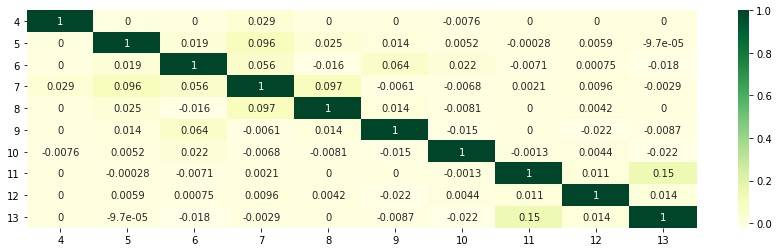

In [67]:
# To answer the above question, let's use a heat map on the similarity matrix created using the adjust consine similarity metric
z_min, z_max = item_correlation[:10, :10].min(), item_correlation[:10, :10].max()

import seaborn as sns
fig = plt.figure(figsize=(15,4))
ax = sns.heatmap(item_correlation[:10, :10], annot=True, cmap='YlGn', vmin=z_min, vmax=z_max)
ax.set_xticklabels(dummy_train.columns[:10])
ax.set_yticklabels(dummy_train.columns[:10])
plt.yticks(rotation=0) 

plt.show()


**Compare the performance of the two models using test data and suggest the one that should be deployed. (Evaluation)**

Calculating RMSE for User-Based Model

In [68]:
df_user_based_test = test.pivot(index='review_profilename', columns='beer_beerid', values='review_overall')

mean = np.nanmean(df_user_based_test, axis=1)
test_df_subtracted = (df_user_based_test.T-mean).T

# User Similarity Matrix
test_user_correlation = 1 - pairwise_distances(test_df_subtracted.fillna(0), metric='cosine')
test_user_correlation[np.isnan(test_user_correlation)] = 0
print(test_user_correlation)

[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


In [69]:
# Setting all the negatively correlated values to 0 as these don't depict any similarity
test_user_correlation[test_user_correlation<0]=0

test_user_predicted_ratings = np.dot(test_user_correlation, df_user_based_test.fillna(0))
test_user_predicted_ratings

array([[6.83295226e-02, 2.19175416e-02, 8.74058350e-02, ...,
        0.00000000e+00, 1.33932228e-01, 6.23798104e-02],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [6.18336463e-04, 2.44525360e-01, 7.17455984e-01, ...,
        3.09963003e-02, 0.00000000e+00, 2.99028631e-01],
       ...,
       [0.00000000e+00, 1.33317838e-01, 6.34434072e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [70]:
# Predictions for the beers already rated by the users
test_user_final_rating = np.multiply(test_user_predicted_ratings,dummy_test)

In [71]:
# Calculating the RMSE for only the beers rated by the user. For RMSE, let's normalise the rating to (0,5) range
from sklearn.preprocessing import MinMaxScaler
from numpy import *

X  = test_user_final_rating.copy() 

scaler = MinMaxScaler(feature_range=(0, 5))
print(scaler.fit(X))
y = (scaler.transform(X))

print(y)

MinMaxScaler(copy=True, feature_range=(0, 5))
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [72]:
test_ = test.pivot(index='review_profilename', columns='beer_beerid', values='review_overall')

In [73]:
# Finding total non-NaN value
total_non_nan = np.count_nonzero(y)

In [74]:
# Calculating RMSE of the user-based model
rmse = (sum(sum((test_ - y )**2))/total_non_nan)**0.5
print(round(rmse,2))

1.82


Calculating RMSE for Item-based model

In [75]:
df_item_based_test = test.pivot(index='review_profilename', columns='beer_beerid', values='review_overall').T

mean = np.nanmean(df_item_based_test, axis=1)
test_df_subtracted = (df_item_based_test.T-mean).T

# User Similarity Matrix
test_item_correlation = 1 - pairwise_distances(test_df_subtracted.fillna(0), metric='cosine')
test_item_correlation[np.isnan(test_item_correlation)] = 0
print(test_item_correlation)

[[1.         0.         0.         ... 0.         0.         0.        ]
 [0.         1.         0.01050951 ... 0.         0.         0.        ]
 [0.         0.01050951 1.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 1.         0.         0.        ]
 [0.         0.         0.         ... 0.         1.         0.33949509]
 [0.         0.         0.         ... 0.         0.33949509 1.        ]]


In [76]:
# Setting all the negatively correlated values to 0 as these don't depict any similarity
test_item_correlation[test_item_correlation<0]=0

test_item_predicted_ratings = np.dot(test_item_correlation, df_item_based_test.fillna(0)).T
test_item_predicted_ratings

array([[3.26048437e-01, 2.03571741e-01, 3.45361517e-02, ...,
        0.00000000e+00, 2.75578732e-04, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 4.51242027e-02, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 1.42588858e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 1.96194359e-02, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [77]:
# Predictions for the users that gave a rating
test_item_final_rating = np.multiply(test_item_predicted_ratings,dummy_test)

In [78]:
test_item_final_rating.head()

beer_beerid,4,5,6,7,8,9,10,11,12,13,...,75978,76144,76170,76192,76323,76375,76440,76521,76525,76816
review_profilename,,,,,,,,,,,,,,,,,,,,,
0110x011,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
01Ryan10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
05Harley,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0tt0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1001111,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [79]:
# Calculating the RMSE for only the users that rated for beers. For RMSE, let's normalise the rating to (0,5) range
from sklearn.preprocessing import MinMaxScaler
from numpy import *

X  = test_item_final_rating.copy() 

scaler = MinMaxScaler(feature_range=(0, 5))
print(scaler.fit(X))
y = (scaler.transform(X))

print(y)

MinMaxScaler(copy=True, feature_range=(0, 5))
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [80]:
test2_ = test.pivot(index='review_profilename', columns='beer_beerid', values='review_overall')

In [81]:
# Finding total non-NaN value
total_non_nan = np.count_nonzero(y)

In [82]:
# Calculating RMSE of the user-based model
rmse = (sum(sum((test2_ - y )**2))/total_non_nan)**0.5
print(round(rmse,2))

2.5


We can see that the User-Based Collaborative Filtering model performed better than the Item-Based one when considering the rmse.
- The RMSE for the User-based model was 1.82
- The RMSE for the Item-based model was 2.5

**Give the names of the top 5 beers that you would recommend to the users 'cokes', 'genog' and 'giblet' using both the models.**

In [83]:
# Top 5 beers to recommend to the mentioned users using the User Based Model
user_final_rating_final = user_final_rating.reset_index()

users = ['cokes', 'genog', 'giblet']

for i in users:
    index_flag = user_final_rating_final.loc[user_final_rating_final['review_profilename']==i, :].index[0]
    print('Top 5 beers to recommend using our User-Based Model to', i)
    print(user_final_rating.iloc[index_flag].sort_values(ascending=False)[0:5])
    print('\n')


Top 5 beers to recommend using our User-Based Model to cokes
beer_beerid
1093    25.274568
412     25.246517
92      24.321427
276     24.111357
1904    24.003248
Name: cokes, dtype: float64


Top 5 beers to recommend using our User-Based Model to genog
beer_beerid
2093    32.842668
1093    32.263179
4083    29.814257
412     29.430562
1013    26.725405
Name: genog, dtype: float64


Top 5 beers to recommend using our User-Based Model to giblet
beer_beerid
412     43.343257
2093    42.653815
1904    40.723405
355     40.330353
1708    37.576957
Name: giblet, dtype: float64




In [84]:
# Top 5 beers to recommend to the mentioned users using the Item Based Model
# Top 5 beers to recommend to the mentioned users using the User Based Model
item_final_rating_final = item_final_rating.reset_index()

users = ['cokes', 'genog', 'giblet']

for i in users:
    index_flag = item_final_rating_final.loc[item_final_rating_final['review_profilename']==i, :].index[0]
    print('Top 5 beers to recommend using our Item-Based Model to', i)
    print(item_final_rating.iloc[index_flag].sort_values(ascending=False)[0:5])
    print('\n')


Top 5 beers to recommend using our Item-Based Model to cokes
beer_beerid
1129     20.891205
7033     20.663289
12335    20.160433
31196    19.889658
9490     19.425756
Name: cokes, dtype: float64


Top 5 beers to recommend using our Item-Based Model to genog
beer_beerid
36014    6.445937
1913     5.876540
46407    5.672334
41008    5.636992
44951    5.556025
Name: genog, dtype: float64


Top 5 beers to recommend using our Item-Based Model to giblet
beer_beerid
36014    6.672341
25590    6.131726
5154     6.033492
22139    5.711136
844      5.673259
Name: giblet, dtype: float64


